<a href="https://colab.research.google.com/github/dexterrxx31/DeepLearning_PyTorch/blob/master/Object_classification_DNN_feedforward_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images of everyday objects using a deep neural network

The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc. 

In this project, I will:

1. Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
2. Set up a training pipeline to train a neural network on a GPU
2. Experiment with different network architectures & hyperparameters


In [50]:
#importing necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## Exploring the CIFAR10 dataset

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
#Size of training dataset
dataset_size = 50000
#Size of training dataset
test_dataset_size = 10000

## Classes present in dataset

In [4]:
classes = dataset.classes
classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
#Number of classes
num_classes = 10
num_classes

10


**Shape of Dataset**

In [6]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 4
Label (textual): deer


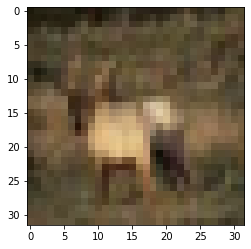

In [8]:
img, label = dataset[3]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

## Preparing the data for training

We'll use a validation set with 5000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [10]:
torch.manual_seed(1)
val_size = 5000
train_size = len(dataset) - val_size
print(train_size)

45000


Let's use the `random_split` method to create the training & validation sets

In [11]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders to load the data in batches.

In [12]:
batch_size=128

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])


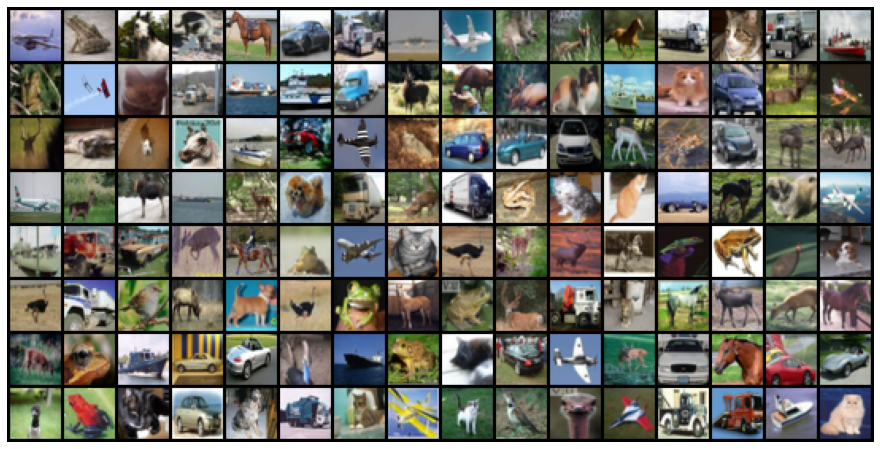

In [19]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. In fact, we can extend this model to solve any image classification problem.

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We can also use the exact same training loop as before. I hope you're starting to see the benefits of refactoring our code into reusable functions.

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.

In [23]:
torch.cuda.is_available()

True

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [27]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [29]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch


In [33]:
input_size = 3*32*32
output_size = 10

In [34]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 2048)
        # hidden layer 2
        self.linear2 = nn.Linear(2048,1024)
        # output layer
        self.linear3 = nn.Linear(1024, output_size)
        
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 3
        out = self.linear3(out)
        # Apply activation function
        out=F.relu(out)
        # Get predictions using output layer
        return out

You can now instantiate the model, and move it the appropriate device.

In [35]:
model = to_device(CIFAR10Model(), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [36]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09271599352359772, 'val_loss': 2.303405523300171}]

**Train the model using the `fit` function to reduce the validation loss & improve accuracy.**

Leverage the interactive nature of Jupyter to train the model in multiple phases, adjusting the no. of epochs & learning rate each time based on the result of the previous training phase.

In [37]:
history += fit(20, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.0558, val_acc: 0.2906
Epoch [1], val_loss: 1.9353, val_acc: 0.3181
Epoch [2], val_loss: 1.7290, val_acc: 0.3882
Epoch [3], val_loss: 1.7094, val_acc: 0.3892
Epoch [4], val_loss: 1.5960, val_acc: 0.4381
Epoch [5], val_loss: 1.7262, val_acc: 0.3837
Epoch [6], val_loss: 1.5347, val_acc: 0.4485
Epoch [7], val_loss: 1.5654, val_acc: 0.4346
Epoch [8], val_loss: 1.4519, val_acc: 0.4861
Epoch [9], val_loss: 1.7068, val_acc: 0.3934
Epoch [10], val_loss: 1.5220, val_acc: 0.4552
Epoch [11], val_loss: 1.4194, val_acc: 0.4944
Epoch [12], val_loss: 1.4686, val_acc: 0.4822
Epoch [13], val_loss: 1.4614, val_acc: 0.4827
Epoch [14], val_loss: 1.3860, val_acc: 0.5014
Epoch [15], val_loss: 1.4055, val_acc: 0.5121
Epoch [16], val_loss: 1.4118, val_acc: 0.4957
Epoch [17], val_loss: 1.3671, val_acc: 0.5154
Epoch [18], val_loss: 1.3678, val_acc: 0.5150
Epoch [19], val_loss: 1.3570, val_acc: 0.5244


In [39]:
history += fit(10, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.2682, val_acc: 0.5602
Epoch [1], val_loss: 1.2686, val_acc: 0.5637
Epoch [2], val_loss: 1.2655, val_acc: 0.5612
Epoch [3], val_loss: 1.2682, val_acc: 0.5644
Epoch [4], val_loss: 1.2666, val_acc: 0.5669
Epoch [5], val_loss: 1.2689, val_acc: 0.5656
Epoch [6], val_loss: 1.2760, val_acc: 0.5592
Epoch [7], val_loss: 1.2741, val_acc: 0.5648
Epoch [8], val_loss: 1.2698, val_acc: 0.5629
Epoch [9], val_loss: 1.2685, val_acc: 0.5623


In [40]:
history += fit(10, 0.001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.2600, val_acc: 0.5675
Epoch [1], val_loss: 1.2600, val_acc: 0.5675
Epoch [2], val_loss: 1.2601, val_acc: 0.5664
Epoch [3], val_loss: 1.2609, val_acc: 0.5679
Epoch [4], val_loss: 1.2614, val_acc: 0.5673
Epoch [5], val_loss: 1.2606, val_acc: 0.5687
Epoch [6], val_loss: 1.2617, val_acc: 0.5681
Epoch [7], val_loss: 1.2615, val_acc: 0.5699
Epoch [8], val_loss: 1.2609, val_acc: 0.5683
Epoch [9], val_loss: 1.2604, val_acc: 0.5687


In [41]:
history += fit(10, 0.0001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.2603, val_acc: 0.5679
Epoch [1], val_loss: 1.2603, val_acc: 0.5685
Epoch [2], val_loss: 1.2603, val_acc: 0.5679
Epoch [3], val_loss: 1.2604, val_acc: 0.5675
Epoch [4], val_loss: 1.2604, val_acc: 0.5679
Epoch [5], val_loss: 1.2604, val_acc: 0.5683
Epoch [6], val_loss: 1.2605, val_acc: 0.5679
Epoch [7], val_loss: 1.2603, val_acc: 0.5683
Epoch [8], val_loss: 1.2604, val_acc: 0.5687
Epoch [9], val_loss: 1.2605, val_acc: 0.5679


Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. You can train some more if you can see the scope for further improvement.

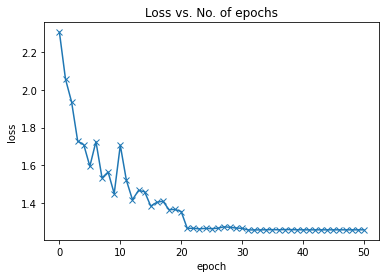

In [42]:
plot_losses(history)

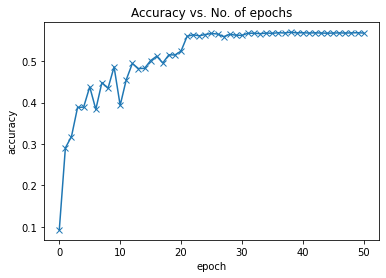

In [43]:
plot_accuracies(history)

Finally, evaluate the model on the test dataset report its final performance.

In [44]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.5702148675918579, 'val_loss': 1.2353261709213257}

Recording our results by completing the section below, then we can come back and try a different architecture & hyperparameters.

## Recoding your results

As your perform multiple experiments, it's important to record the results in a systematic fashion, so that you can review them later and identify the best approaches that you might want to reproduce or build upon later. 

**Model's architecture Definition **

E.g. `"3 layers (16,32,10)"` (16, 32 and 10 represent output sizes of each layer)

In [45]:
arch = "3 layer (2048,1024,10)"

In [46]:
#Learning Rate
lrs = [0.1,0.01,0.001,0.0001]

In [47]:
#Number of Epochs
epochs = [20,10,10,10]

In [48]:
#Test Accuracy and Loss
test_acc = 0.566601574420929
test_loss = 1.2393358945846558

Finally, let's save the trained model weights to disk, so we can use this model later.

In [49]:
torch.save(model.state_dict(), 'cifar10-feedforward.pth')